In [1]:
from fastai.vision.all import *
from fastbook import *

In [2]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Training a Neural Net
This example trains a simple neural net on the mnist sample data set. We predict if an image is a 3 or 7

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class MNISTDataset(Dataset):
    def __init__(self, path, transform=None, target_transform=None):
        self.path = path
        self.transform = transform
        self.target_transform = target_transform
        self.image_paths = list(flatten([(i.ls()) for i in self.path.ls()]))
    
    def __len__(self):
        return sum([len((self.path/str(i)).ls()) for i in self.path.ls()])
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path)
        label = img_path.parent.name
        if self.transform:
            img = self.transform(img)
        if self.target_transform:
            label = self.target_transform(label)
        return img, torch.tensor(label, dtype=torch.float32).unsqueeze(0)
    


In [5]:
train_ds = MNISTDataset(path/"train", transform=ToTensor(), target_transform=lambda x: x == "3")

In [6]:
def show_sample(ds, rows, cols, seed=42):
    rand = random.Random(seed)
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols * rows +1):
        sample_idx = rand.randrange(len(ds))
        img, label = ds[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

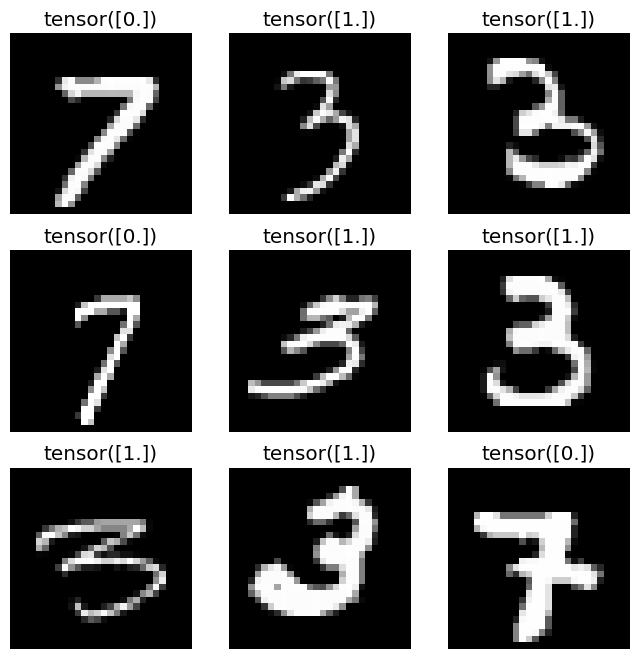

In [7]:
show_sample(train_ds, 3, 3)

In [8]:
valid_ds = MNISTDataset(path/"valid", transform=ToTensor(), target_transform=lambda x: x == "3")

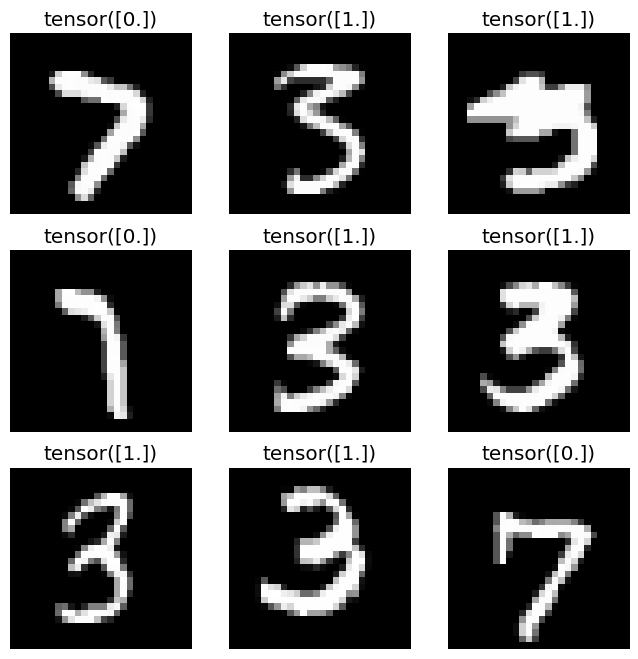

In [9]:
show_sample(valid_ds, 3, 3)

In [10]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=64)

In [11]:
from tqdm.notebook import tqdm
from pandas import DataFrame
from IPython.display import display
from ipywidgets import Box

class JLearner:
    def __init__(self, model, loss_func, opt_func, train_dl, valid_dl, metrics=None):
        #self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = torch.device("cpu")
        self.model = model.to(self.device)
        self.loss_func = loss_func
        self.opt_func = opt_func
        self.train_dl = train_dl
        self.valid_dl = valid_dl
        self.metrics = metrics if type(metrics) in (list, tuple) else [metrics]
        self.epoch_results = []
        self.o = True

    def fit(self, epochs):
        self.validate_epoch()
        for epoch in tqdm(range(epochs), desc="Epochs"):
            self.train_epoch()
            with torch.no_grad():
                self.validate_epoch()

    def train_epoch(self):

        for xs, ys in self.train_dl:
            xs, ys = xs.to(self.device), ys.to(self.device)
            self.train_batch(xs, ys)
    
    def train_batch(self, xs, ys):
        preds = self.model(xs)
        loss = self.loss_func(preds, ys)
        loss.backward()
        self.opt_func.step()
        self.opt_func.zero_grad()

    def validate_epoch(self):
        batch_results = []
        for xs, ys in self.valid_dl:
            xs, ys = xs.to(self.device), ys.to(self.device)
            loss, metrics = self.validate_batch(xs, ys)
            batch_results.append([loss] + [metric.item() for _, metric in metrics])
        self.epoch_results.append(np.mean(batch_results, axis=0))
        df = DataFrame(self.epoch_results, columns=["loss"] + [metric.__name__ for metric in self.metrics])
        self.o = display(df, display_id="validation_results", clear=True)


    def validate_batch(self, xs, ys):
        preds = self.model(xs)
        loss = self.loss_func(preds, ys)
        metrics = [(metric.__name__, metric(preds, ys)) for metric in self.metrics]
        return loss.item(), metrics



In [12]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [13]:
def batch_accuracy(xb, yb):
    correct = (xb>0.5) == yb
    return correct.float().mean()

In [14]:
model = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 30), nn.ReLU(), nn.Linear(30, 1), nn.Sigmoid())
loss_func = mnist_loss
opt_func = SGD(model.parameters(), lr=0.1)
learn = JLearner(model, loss_func, opt_func, train_dl, valid_dl, metrics=batch_accuracy)

In [15]:
learn.fit(5)

,loss,batch_accuracy
0,0.509987,0.396864
1,0.039550,0.971680
2,0.031704,0.975586
3,0.028291,0.977051
4,0.026121,0.979492
5,0.024519,0.979004


## Adversarial Example
This example tries to convert a 7 to a 3 using the same techniques above

tensor([0.])

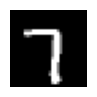

In [16]:
img, label = valid_ds[1325]
show_image(img.squeeze(), cmap="gray")
display(label)

In [17]:
def calc_adv_img(img, noise_img):
    adv_img = img + (2*sigmoid(noise_img)-1)
    adv_img = torch.clamp(adv_img, 0, 1)
    #adv_img = img + sigmoid(noise_img)
    return adv_img
    #return img 

In [18]:
def adv_model(img, noise_img):
    return model(calc_adv_img(img, noise_img))

<Axes: >

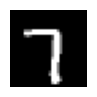

In [19]:
noise_img = torch.zeros(img.shape, requires_grad=True)
show_image(calc_adv_img(img, noise_img).squeeze(), cmap="gray")

In [20]:
def adv_loss(prediction, noise_img, original_img):
    noise_power = noise_img.abs().sum()
    return -5.0*torch.log(prediction) + 0.2*noise_power


In [21]:
noise_img = torch.zeros(img.shape, requires_grad=True)
img_dev = img.to(learn.device)
noise_dev = noise_img.to(learn.device)
model(img_dev)

tensor([[0.0013]], grad_fn=<SigmoidBackward0>)

In [22]:
num_epoch = 1000
sgd = SGD([noise_dev], lr=0.11)
for epoch in range(num_epoch):
    preds = adv_model(img_dev, noise_dev)
    #if preds.item() > 0.6:
    #    break
    loss = adv_loss(preds, noise_dev, img_dev)
    loss.backward()
    sgd.step()
    sgd.zero_grad()
    with torch.no_grad():
        preds = adv_model(img_dev, noise_dev)
        loss = adv_loss(preds, noise_dev, img_dev)
        if epoch % (num_epoch/10) == 0:
            print(loss.item(), preds.item(), noise_dev.abs().sum().item())

25.033588409423828 0.019757194444537163 27.062002182006836
9.006372451782227 0.8003026247024536 39.462730407714844
8.898905754089355 0.8020345568656921 38.97943878173828
8.877422332763672 0.7983251810073853 38.756126403808594
8.913603782653809 0.7988259792327881 38.95271301269531
8.897480964660645 0.7983980178833008 38.85870361328125
8.965872764587402 0.806667685508728 39.458274841308594
8.89414119720459 0.7941275835037231 38.70792770385742
8.91778564453125 0.7978670597076416 38.94359588623047
8.936525344848633 0.7982958555221558 39.050724029541016


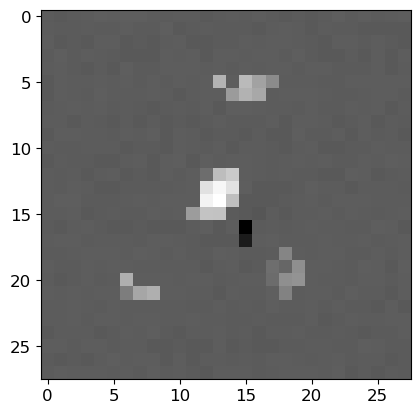

In [23]:
plt.imshow(noise_dev.squeeze().detach().numpy(), cmap="gray")

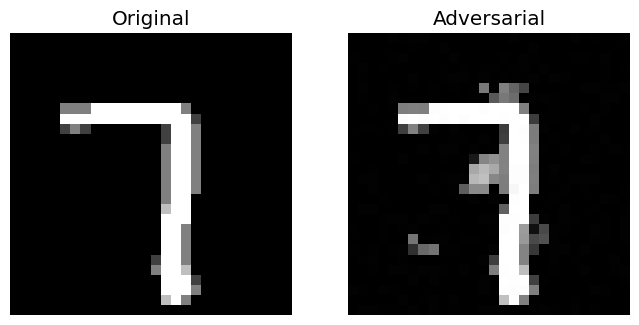

In [24]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.axis("off")
plt.imshow(img.squeeze(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Adversarial")
plt.axis("off")
plt.imshow(calc_adv_img(img, noise_dev).squeeze().detach().numpy(), cmap="gray")

In [25]:
calc_adv_img(img, noise_img).max(), calc_adv_img(img, noise_img).min(), img.max(), img.min()

(tensor(1., grad_fn=<MaxBackward1>),
 tensor(0., grad_fn=<MinBackward1>),
 tensor(1.),
 tensor(0.))

In [26]:
model(img_dev), adv_model(img_dev, noise_dev)

(tensor([[0.0013]], grad_fn=<SigmoidBackward0>),
 tensor([[0.7984]], grad_fn=<SigmoidBackward0>))

In [27]:
img.sum()/(28*28), calc_adv_img(img, noise_dev).sum()/(28*28)

(tensor(0.0976), tensor(0.1149, grad_fn=<DivBackward0>))